In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from easydict import EasyDict as edict
from collections import defaultdict as ddict
import torch
import time
from tqdm.autonotebook import tqdm
from scipy import signal
import time
%matplotlib inline
import pickle

In [2]:
from cUtils import *
from tmpUtils import *
from Rfuns import bw_nrd0_R

In [4]:
dataPath = Path("../data")

In [5]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [6]:
realPath = dataPath/"realmat.pkl"
with open(realPath, "rb") as f:
    real = pickle.load(f)

In [125]:
R = 4
dT = 719
dF = 5
chgs = np.array([10, 20, 34, 50, 67, 70, 87])*7
chgsT = np.concatenate([[0], chgs, [dT]])


res = np.linalg.eig(real.Amat)
U = res[1]
eigVs = U[0]
Uinv = np.linalg.inv(U)


pUinv = torch.tensor(Uinv[:R, :])
X = torch.tensor(real.X).type_as(pUinv)
newX = X.permute(1, 2, 0).matmul(pUinv.T)[:, :dT, :]

eigIdx = [False, False]
eigIdx = [False, False, True, True]
#eigIdx = [False, False, True, True, True, True]
mus = GenFVecs(R, eigIdx, chgsT) 
tenMus = torch.tensor(mus).type_as(pUinv)
newY = newX * tenMus.T.unsqueeze(dim=0) + torch.complex(torch.randn(newX.shape), torch.randn(newX.shape))*10

In [126]:
newX.shape

torch.Size([5, 719, 4])

In [127]:
lastTheta = torch.randn(2*R*(dT-1))
fixedParas = torch.randn(2*R, dF)

In [128]:
opt = OneStepOpt(X=torch.tensor(real.X), Y=torch.tensor(real.Y), lastTheta=lastTheta, penalty="SCAD", 
                 is_ConGrad=False,
                 fixedParas=fixedParas, pUinv=pUinv,
                beta=1, alp=0.9, a=2.7, lam=2e1, iterC=1e-8, iterNum=100)

In [129]:
opt.NewXr = newX.real
opt.NewXi = newX.imag
opt.NewYr = newY.real
opt.NewYi = newY.imag

In [130]:
opt(True, True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [131]:
eMus = opt.GamMat.cpu().numpy()
eThetas = opt.ThetaMat.cpu().numpy()
tMus = np.concatenate([mus.real, mus.imag])
eDiffMus = np.diff(eMus)

([], [])

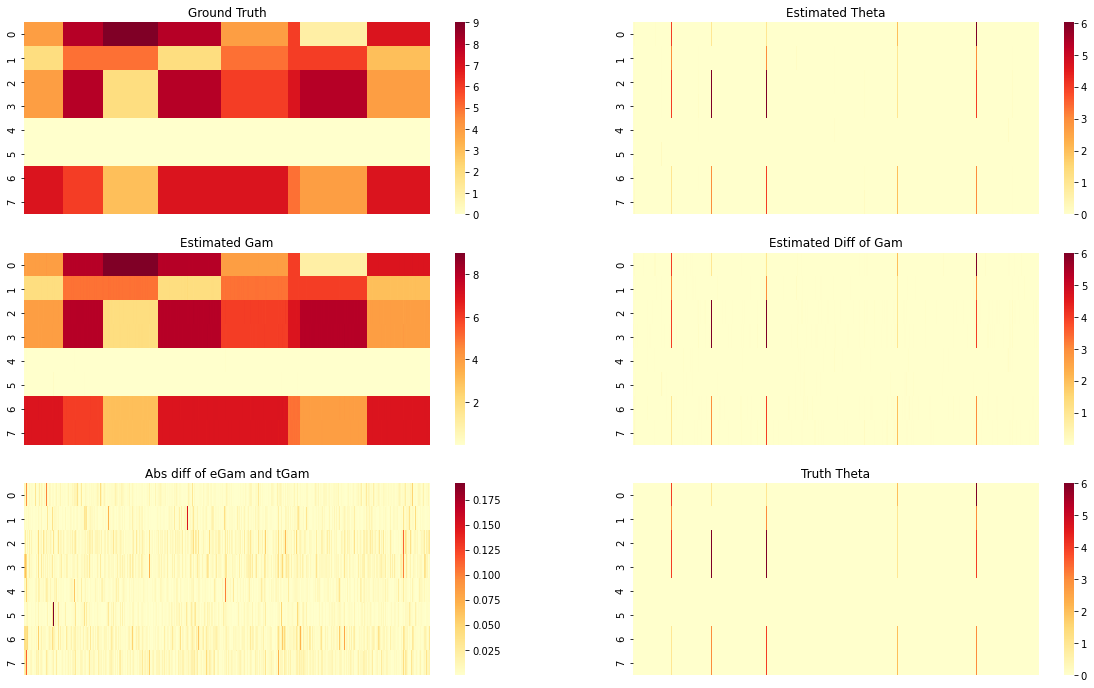

In [132]:
plt.figure(figsize=[20, 12])

is_annot = False
plt.subplot(321)
plt.title("Ground Truth")
sns.heatmap(np.abs(tMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(323)
plt.title("Estimated Gam")
sns.heatmap(np.abs(eMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(325)
plt.title("Abs diff of eGam and tGam")
sns.heatmap(np.abs(tMus-eMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(322)
plt.title("Estimated Theta")
sns.heatmap(np.abs(eThetas), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(324)
plt.title("Estimated Diff of Gam")
sns.heatmap(np.abs(eDiffMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(326)
plt.title("Truth Theta")
sns.heatmap(np.abs(np.diff(tMus)), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

### The data term error

In [63]:
est = torch.zeros_like(tenMus)
est.real = torch.tensor(eMus[:4, :])
est.imag = torch.tensor(eMus[4:, :])

In [64]:
torch.norm(newY - newX * est.T.unsqueeze(dim=0))/1

tensor(0.1342)

In [66]:
torch.norm(newY - newX * tenMus.T.unsqueeze(dim=0))/1

tensor(0.)

### The solution with `cxvpy` pkg

Only apply when optimizing for dF

In [ ]:
import cvxpy as cp

In [20]:
newXnp = newX.permute(1, 2, 0).cpu().numpy()
newYnp = newY.permute(1, 2, 0).cpu().numpy()
newXrnp = newXnp.real
newXinp = newXnp.imag
newYrnp = newYnp.real
newYinp = newYnp.imag

In [21]:
D = opt.D
R2 = opt.R2

cvxlam = opt.paras.lam
beta = opt.paras.beta
alp = opt.paras.alp
rhos = cp.Parameter(R2*(D-1), value=np.ones(R2*(D-1)))

In [22]:
GamsVec = cp.Variable(R2*D, value=np.random.randn(R2*D))
ThetasVec = cp.Variable(R2*(D-1), value=lastTheta.cpu().numpy())
Gams = cp.reshape(GamsVec, (R2, D))
Thetas = cp.reshape(ThetasVec, (R2, D-1))

In [25]:
dataLoss = 0
for i in range(newXnp.shape[0]):
    cXrdat = newXrnp[i, :, :]
    cXidat = newXinp[i, :, :]
    cYrdat = newYrnp[i, :, :]
    cYidat = newYinp[i, :, :]
    cLoss1 = cp.sum_squares(cYrdat - cp.multiply(cXrdat, Gams[:4, :]) + cp.multiply(cXidat, Gams[4:, :]))
    cLoss2 = cp.sum_squares(cYidat - cp.multiply(cXrdat, Gams[4:, :]) - cp.multiply(cXidat, Gams[:4, :]))
    dataLoss = dataLoss +  cLoss1 + cLoss2
dataLoss = dataLoss/2

In [26]:
penalty =  cvxlam * cp.sum(cp.norm(Thetas, axis=0))

In [27]:
diffGamsVec = GamsVec[R2:] - GamsVec[:-R2]
resid = diffGamsVec - ThetasVec

In [28]:
arg1 = dataLoss - rhos @ resid + beta*cp.sum_squares(resid)/2
arg2 = penalty - rhos @ resid + beta*cp.sum_squares(resid)/2

In [29]:
for it in tqdm(range(100)):
    cp.Problem(cp.Minimize(arg1), [Thetas == Thetas.value]).solve()
    rhos.value = rhos.value - alp*beta*resid.value
    cp.Problem(cp.Minimize(arg2), [Gams == Gams.value]).solve()
    rhos.value = rhos.value - alp*beta*resid.value

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

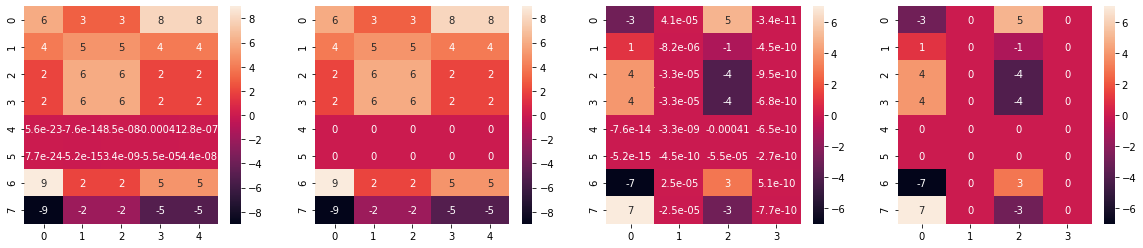

In [30]:
plt.figure(figsize=[20, 4])
plt.subplot(141)
sns.heatmap(Gams.value, annot=True)
plt.subplot(142)
sns.heatmap(tMus, annot=True)
plt.subplot(143)
sns.heatmap(Thetas.value, annot=True)
plt.subplot(144)
sns.heatmap(np.diff(tMus), annot=True)

### Check for the first step

In [329]:
cp.Problem(cp.Minimize(arg1), [Thetas == Thetas.value]).solve()

17.077393583063262

In [330]:
GamsVec.value 

array([ 2.99999975e+00,  9.99999913e-01,  2.99999803e+00,  2.99999877e+00,
       -3.24030379e-07, -3.92842726e-07,  7.99999774e+00, -8.00000208e+00,
        3.00000033e+00,  1.00000043e+00,  3.00000473e+00,  3.00000290e+00,
        1.93852152e-07,  3.35000960e-07,  8.00000023e+00, -7.99999381e+00,
        2.80989394e+00,  2.85927555e+00,  4.27128560e+00,  5.07928848e+00,
       -4.61901866e-01,  6.12759272e-01,  5.69685161e+00, -6.15438561e+00,
        2.01054056e+00,  3.74735578e+00,  4.60571445e+00,  4.35211998e+00,
       -4.98040086e-02,  1.49057979e-01,  3.65776273e+00, -3.52337865e+00,
        2.00047785e+00,  4.00004241e+00,  6.00012189e+00,  6.00078153e+00,
        8.35351235e-04,  1.07717432e-04,  2.00469233e+00, -2.00148513e+00])

In [93]:
rhos.value = rhos.value - alp*beta*resid.value

In [95]:
cp.Problem(cp.Minimize(arg2), [Gams == Gams.value]).solve()

4.587992530072123

In [236]:
opt.updateVecGam()

<AxesSubplot:>

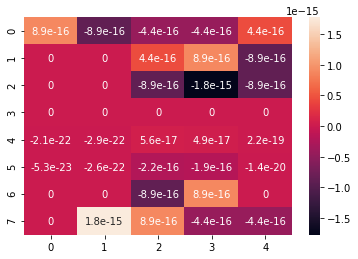

In [331]:
diff = colStackFn(opt.newVecGam, opt.R2).cpu().numpy() - Gams.value
sns.heatmap(diff, annot=True)

In [94]:
opt.updateHRho()

In [96]:
opt.updateThetaGL()

In [100]:
opt.lastTheta.cpu().numpy() - ThetasVec.value

array([-1.56304676e-06,  5.64167041e-07, -2.00680723e-06, -1.43018430e-06,
       -7.84791726e-07,  7.03845044e-07, -1.93773010e-06, -1.20816089e-06,
        7.38476828e-06,  1.38588433e-05,  3.21194467e-05,  2.48962735e-06,
       -6.08488254e-07,  3.90952510e-05,  1.56005123e-05,  1.98333309e-05,
       -5.34824688e-06, -8.47335970e-06, -9.98141051e-07, -4.55822759e-06,
       -3.24603791e-06, -5.21343107e-06, -6.19732353e-06, -4.22175394e-06,
        3.53426173e-06,  1.89141030e-06, -1.80568146e-06, -1.39187919e-06,
       -1.52674281e-06, -4.04767448e-06, -4.08206808e-06, -2.94214919e-06])

In [98]:
ThetasVec.value

array([-0.13601718,  0.04909406, -0.17463344, -0.12445543, -0.06829299,
        0.06124904, -0.16862226, -0.10511822,  0.73879954,  3.25898512,
        1.23124355,  0.94187541, -0.48853778, -1.28679493, -1.85136966,
        0.03787476,  0.37977629,  0.03392641,  0.00476   ,  0.44437824,
       -0.03044995, -0.61723254, -0.63058334, -0.11674998,  0.41859455,
        0.22392008, -0.21475719, -0.16589913, -0.18057009, -0.47859404,
       -0.48209789, -0.34842559])

In [91]:
opt.newVecGam = torch.tensor(GamsVec.value)

In [80]:
GamsVec.value

array([ 7.00000000e+00,  1.00000000e+00,  2.00000000e+00,  2.00000000e+00,
       -9.11626903e-11,  1.31147501e-10,  5.00000000e+00, -5.00000000e+00,
        7.00000000e+00,  1.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        1.27043212e-10, -1.13806062e-09,  5.00000000e+00, -5.00000000e+00,
        7.76833030e+00,  3.84201521e+00,  3.85972728e+00,  2.77705188e+00,
       -3.83081281e-01,  1.80890599e-01,  4.07181358e+00, -4.39181918e+00,
        9.00151044e+00,  5.00059731e+00,  3.99727465e+00,  3.99711842e+00,
       -9.22522066e-05,  3.91934491e-05,  4.00127638e+00, -4.00177261e+00,
        8.99999899e+00,  4.99999978e+00,  4.00000236e+00,  4.00000173e+00,
        3.32250081e-07,  3.75245065e-07,  4.00000579e+00, -3.99999592e+00])

### Calculate leftMat and rightVec from simplest method

In [249]:
dF, dT, _ = newX.shape
R = int(opt.R2/2)
leftMat = torch.zeros((opt.R2*opt.D, opt.R2*opt.D)).double()
rightVec = torch.zeros(opt.R2*opt.D).double()
for idxf in range(dF):
    for idxt in range(dT):
        cX = newX[idxf, idxt, :]
        cY = newY[idxf, idxt, :]
        
        DsMat =  genIdenMatfn(idxf+1, opt.R2, opt.D).to_dense()
        cXmat = torch.zeros(opt.R2, opt.R2).double()
        cXrmat = torch.diag(cX.real)
        cXimat = torch.diag(cX.imag)
        cXmat[:R, :R] = cXrmat
        cXmat[R:, R:] = cXrmat
        cXmat[:R, R:] = -cXimat
        cXmat[R:, :R] = cXimat
        leftMatitm = DsMat.T.matmul(cXmat.T).matmul(cXmat).matmul(DsMat)
        
        
        leftMat += leftMatitm
        
        cYvec = torch.cat([cY.real, cY.imag])
        rightVecItm = DsMat.T.matmul(cXmat.T).matmul(cYvec)
        rightVec += rightVecItm

In [250]:
leftMat = leftMat/opt.nD + opt.paras.beta*opt.DiffMatSq
rightVec0 = opt.NewXYR2Sum.flatten()/opt.nD + \
                    DiffMatTOpt(opt.rho + opt.paras.beta * opt.lastTheta, opt.R2)

In [304]:
torch.inverse(leftMat).matmul(rightVec0) - opt.newVecGam

tensor([ 1.7764e-15,  9.9920e-16, -3.1086e-15, -1.3323e-15, -2.1176e-22,
        -4.2352e-22, -8.8818e-15,  7.1054e-15,  1.7764e-15,  1.1102e-15,
         0.0000e+00,  2.2204e-15,  7.9409e-23,  3.7058e-22,  1.7764e-15,
        -6.2172e-15,  8.8818e-16,  8.8818e-16,  8.8818e-16,  1.7764e-15,
         5.5511e-17,  1.1102e-16,  8.8818e-16, -3.5527e-15,  4.4409e-16,
         1.3323e-15,  2.6645e-15,  2.6645e-15,  3.4694e-17,  5.5511e-17,
         4.4409e-16, -1.7764e-15,  2.6645e-15,  0.0000e+00,  7.1054e-15,
         7.1054e-15,  1.0842e-18,  1.3553e-20,  2.6645e-15, -2.2204e-15])

In [255]:
torch.norm(opt.leftMat.to_dense()-leftMat)
torch.norm(opt.NewXYR2Sum.flatten()-rightVec)

tensor(1.1234e-05)

In [269]:
genIdenMatfn(2, opt.R2, opt.D).matmul(rightVec0)

tensor([ 5.1518e+06,  3.3710e+06,  1.5524e+06,  1.5524e+06,  7.9480e-01,
         5.1652e-01,  4.1397e+06, -4.1397e+06])

In [267]:
rightVec

tensor([ 1.8889e+07,  6.1603e+06,  3.1432e+06,  3.1432e+06, -2.0402e+00,
        -2.4200e+00,  8.3817e+06, -8.3817e+06,  5.1518e+06,  3.3710e+06,
         1.5524e+06,  1.5524e+06,  7.9480e-01,  5.1652e-01,  4.1397e+06,
        -4.1397e+06,  6.1084e-01,  9.8256e-01,  9.3977e-01,  2.8099e+00,
        -8.7426e-01,  1.0789e+00, -2.6017e-01, -7.8960e-01,  2.1653e+00,
         1.7639e+01,  3.5753e-01, -1.0364e+00,  2.8827e-01,  3.6161e-01,
         7.3973e-01,  2.4721e-02,  4.2644e+03,  2.2725e+04,  2.2251e+03,
         2.2256e+03,  1.8314e+00,  4.6301e-01,  7.4131e+02, -7.4025e+02])

In [311]:
(leftMat.matmul(torch.tensor(GamsVec.value)) - rightVec0)

tensor([ 1.5905,  0.5340,  2.0607,  1.2831,  2.0373,  2.4167,  2.3663,  2.1780,
        -0.4164, -2.1638, -3.3398, -2.3372, -0.4310, -0.7377,  1.2689, -4.6218,
        -0.2718,  1.1946,  0.4082,  0.0408,  0.1477, -0.6339, -1.1311,  1.3373,
         0.1048,  0.9278,  2.2981,  2.9356,  0.0747, -0.5826, -2.4074,  2.0674,
        -1.0071, -0.4927, -1.4272, -1.9223, -1.8287, -0.4625, -0.0967, -0.9608])

In [310]:
(leftMat.matmul(torch.tensor(GamsVec.value)) - rightVec0)/rightVec0

tensor([ 8.4204e-08,  8.6691e-08,  6.5562e-07,  4.0822e-07, -9.9861e-01,
        -9.9861e-01,  2.8232e-07, -2.5985e-07, -8.0819e-08, -6.4188e-07,
        -2.1514e-06, -1.5056e-06, -5.4223e-01, -1.4281e+00,  3.0652e-07,
         1.1165e-06, -4.4499e-01,  1.2158e+00,  4.3433e-01,  1.4525e-02,
        -1.6889e-01, -5.8750e-01,  4.3474e+00, -1.6936e+00,  4.8376e-02,
         5.2600e-02,  6.4278e+00, -2.8326e+00,  2.5921e-01, -1.6111e+00,
        -3.2544e+00,  8.3628e+01, -2.3616e-04, -2.1680e-05, -6.4140e-04,
        -8.6374e-04, -9.9857e-01, -9.9899e-01, -1.3047e-04,  1.2979e-03])

In [306]:
leftMat.matmul(opt.newVecGam) - rightVec0

tensor([-7.4506e-09, -6.5193e-09,  3.2596e-09,  1.8626e-09,  8.8818e-16,
         2.6645e-15,  9.3132e-09, -6.5193e-09, -2.7940e-09, -3.2596e-09,
         2.3283e-10, -9.3132e-10, -2.2204e-16, -1.1102e-15, -4.6566e-10,
         3.7253e-09,  6.6613e-16, -5.5511e-16,  6.6613e-16,  4.4409e-16,
        -1.1102e-16,  0.0000e+00, -1.2212e-15,  1.1102e-15,  2.6645e-15,
        -1.0658e-14,  2.8866e-15,  2.8866e-15, -5.5511e-17, -3.3307e-16,
         3.1086e-15, -2.7756e-15, -4.5475e-12,  0.0000e+00, -3.1832e-12,
        -2.2737e-12, -1.9984e-15,  5.5511e-17, -1.1369e-12,  7.9581e-13])

In [309]:
rightVec0

tensor([ 1.8889e+07,  6.1603e+06,  3.1432e+06,  3.1432e+06, -2.0402e+00,
        -2.4200e+00,  8.3817e+06, -8.3817e+06,  5.1518e+06,  3.3710e+06,
         1.5524e+06,  1.5524e+06,  7.9480e-01,  5.1652e-01,  4.1397e+06,
        -4.1397e+06,  6.1084e-01,  9.8256e-01,  9.3977e-01,  2.8099e+00,
        -8.7426e-01,  1.0789e+00, -2.6017e-01, -7.8960e-01,  2.1653e+00,
         1.7639e+01,  3.5753e-01, -1.0364e+00,  2.8827e-01,  3.6161e-01,
         7.3973e-01,  2.4721e-02,  4.2644e+03,  2.2725e+04,  2.2251e+03,
         2.2256e+03,  1.8314e+00,  4.6301e-01,  7.4131e+02, -7.4025e+02])

In [307]:
torch.tensor(GamsVec.value) - opt.newVecGam

tensor([ 2.5261e-07,  8.6690e-08,  1.9668e-06,  1.2246e-06,  3.2358e-07,
         3.9230e-07,  2.2585e-06,  2.0788e-06, -3.2467e-07, -4.2769e-07,
        -4.7231e-06, -2.8983e-06, -1.9350e-07, -3.3470e-07, -2.3114e-07,
        -6.1775e-06, -1.4119e-01,  7.2203e-01,  8.9572e-01,  8.3742e-01,
         9.8664e-02, -3.9059e-01, -1.3885e+00,  1.4252e+00, -1.0640e-02,
         2.5236e-01,  1.3839e+00,  1.6346e+00,  4.9733e-02, -1.4888e-01,
        -1.6469e+00,  1.5140e+00, -4.7719e-04, -4.2292e-05, -1.1653e-04,
        -7.7430e-04, -8.3416e-04, -1.0760e-04, -4.6920e-03,  1.4887e-03])

In [308]:
opt.newVecGam

tensor([ 3.0000e+00,  1.0000e+00,  3.0000e+00,  3.0000e+00, -3.2403e-07,
        -3.9284e-07,  8.0000e+00, -8.0000e+00,  3.0000e+00,  1.0000e+00,
         3.0000e+00,  3.0000e+00,  1.9385e-07,  3.3500e-07,  8.0000e+00,
        -8.0000e+00,  2.8099e+00,  2.8593e+00,  4.2713e+00,  5.0793e+00,
        -4.6190e-01,  6.1276e-01,  5.6969e+00, -6.1544e+00,  2.0105e+00,
         3.7474e+00,  4.6057e+00,  4.3521e+00, -4.9804e-02,  1.4906e-01,
         3.6578e+00, -3.5234e+00,  2.0005e+00,  4.0000e+00,  6.0001e+00,
         6.0008e+00,  8.3535e-04,  1.0772e-04,  2.0047e+00, -2.0015e+00])